In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
def transformer_stats(depth: int, d_model: int, d_ff: int, seq_len: int):
    stats = {}

    # params
    params = 0
    # attention
    params += d_model             # RMS scale
    params += d_model * 3*d_model # QKV
    params += d_model * d_model   # Out
    # feedforward
    params += d_model             # RMS scale
    params += d_model * 2*d_ff    # GLU up
    params += d_model * d_ff      # GLU down

    params *= depth
    params += d_model # Output head norm

    stats["params"] = params

    # FLOPs (matmuls)
    flops = 0
    # attention
    flops += seq_len * (2 * d_model * 3*d_model) # QKV
    flops += seq_len * seq_len * d_model * 2     # A=QK
    flops += seq_len * seq_len * d_model * 2     # AV
    flops += seq_len * (2 * d_model * d_model)   # Out
    # feedforward
    flops += seq_len * (2 * d_model * 2*d_ff)
    flops += seq_len * (2 * d_model * d_ff)

    flops *= depth

    stats["flops_per_token"] = flops // seq_len

    return stats

In [3]:
device_flops = 71e12
efficiency = 0.6
act_device_flops = efficiency * device_flops

seconds = 60*30    # 30 mins
# seconds = 60*60    # 1h
# seconds = 60*60*2  # 2h
# seconds = 60*60*4  # 4h
# seconds = 60*60*8  # 8h
# seconds = 60*60*16 # 8h

total_flops = seconds * act_device_flops

In [4]:
total_flops

7.668e+16

In [5]:
batch_size = 32
seq_len = 256

depth_width_ratio = 25
d_model = 128

d_ff = 64*((d_model*4*(2/3)) // 64)

In [6]:
d_model, round(d_model/depth_width_ratio), d_ff

(128, 5, 320.0)

In [7]:
model_configs = [
    {"depth": 5, "d_model":   128, "d_ff":  320, "seq_len": seq_len},
    {"depth": 10, "d_model":  256, "d_ff":  640, "seq_len": seq_len},
    {"depth": 15, "d_model":  384, "d_ff": 1024, "seq_len": seq_len},
    {"depth": 20, "d_model":  512, "d_ff": 1344, "seq_len": seq_len},
    {"depth": 26, "d_model":  640, "d_ff": 1664, "seq_len": seq_len},
    {"depth": 31, "d_model":  768, "d_ff": 2048, "seq_len": seq_len},
    {"depth": 36, "d_model":  896, "d_ff": 2368, "seq_len": seq_len},
    {"depth": 41, "d_model": 1024, "d_ff": 2688, "seq_len": seq_len},
]

In [8]:
for mc in model_configs:
    stats = transformer_stats(mc["depth"], mc["d_model"], mc["d_ff"], mc["seq_len"])
    total_tokens = total_flops / ((stats["flops_per_token"] / 2) * 6)
    tokens_per_batch = batch_size * seq_len
    total_steps = total_tokens / tokens_per_batch
    mc["params"] = stats["params"]
    mc["flops_per_token"] = stats["flops_per_token"]
    mc["total_flops"] = total_flops
    mc["total_steps"] = round(total_steps)
    print(mc)

{'depth': 5, 'd_model': 128, 'd_ff': 320, 'seq_len': 256, 'params': 943488, 'flops_per_token': 2539520, 'total_flops': 7.668e+16, 'total_steps': 1228625}
{'depth': 10, 'd_model': 256, 'd_ff': 640, 'seq_len': 256, 'params': 7542016, 'flops_per_token': 17694720, 'total_flops': 7.668e+16, 'total_steps': 176330}
{'depth': 15, 'd_model': 384, 'd_ff': 1024, 'seq_len': 256, 'params': 26553984, 'flops_per_token': 58982400, 'total_flops': 7.668e+16, 'total_steps': 52899}
{'depth': 20, 'd_model': 512, 'd_ff': 1344, 'seq_len': 256, 'params': 62280192, 'flops_per_token': 135004160, 'total_flops': 7.668e+16, 'total_steps': 23111}
{'depth': 26, 'd_model': 640, 'd_ff': 1664, 'seq_len': 256, 'params': 125699200, 'flops_per_token': 268369920, 'total_flops': 7.668e+16, 'total_steps': 11626}
{'depth': 31, 'd_model': 768, 'd_ff': 2048, 'seq_len': 256, 'params': 219462912, 'flops_per_token': 463208448, 'total_flops': 7.668e+16, 'total_steps': 6736}
{'depth': 36, 'd_model': 896, 'd_ff': 2368, 'seq_len': 256

In [26]:
model_results = [
    # 7.668e+16 FLOPs
    # {'depth':  5, 'd_model':  128, 'd_ff':  320, 'seq_len': 256, 'params':    943_488, 'flops_per_token':    2_539_520, 'total_flops': 7.668e+16, 'total_steps': 1228625, 'lr':   3e-4, 'min_valid_loss': }
    
    {'depth': 10, 'd_model':  256, 'd_ff':  640, 'seq_len': 256, 'params':   7_542_016, 'flops_per_token':   17_694_720, 'total_flops': 7.668e+16, 'total_steps': 176330, 'lr':    3e-4, 'min_valid_loss': 3.8506069779396057},
    {'depth': 10, 'd_model':  256, 'd_ff':  640, 'seq_len': 256, 'params':   7_542_016, 'flops_per_token':   17_694_720, 'total_flops': 7.668e+16, 'total_steps': 176330, 'lr':    9e-4, 'min_valid_loss': 3.7916154861450195},
    {'depth': 10, 'd_model':  256, 'd_ff':  640, 'seq_len': 256, 'params':   7_542_016, 'flops_per_token':   17_694_720, 'total_flops': 7.668e+16, 'total_steps': 176330, 'lr':   18e-4, 'min_valid_loss': },
    {'depth': 10, 'd_model':  256, 'd_ff':  640, 'seq_len': 256, 'params':   7_542_016, 'flops_per_token':   17_694_720, 'total_flops': 7.668e+16, 'total_steps': 176330, 'lr':   27e-4, 'min_valid_loss': },
    
    {'depth': 15, 'd_model':  384, 'd_ff': 1024, 'seq_len': 256, 'params':  26_553_984, 'flops_per_token':   58_982_400, 'total_flops': 7.668e+16, 'total_steps':  52899, 'lr':   3e-4, 'min_valid_loss': 3.7982228795687356},
    {'depth': 15, 'd_model':  384, 'd_ff': 1024, 'seq_len': 256, 'params':  26_553_984, 'flops_per_token':   58_982_400, 'total_flops': 7.668e+16, 'total_steps':  52899, 'lr':   9e-4, 'min_valid_loss': 3.734954277674357},
    {'depth': 15, 'd_model':  384, 'd_ff': 1024, 'seq_len': 256, 'params':  26_553_984, 'flops_per_token':   58_982_400, 'total_flops': 7.668e+16, 'total_steps':  52899, 'lr':  18e-4, 'min_valid_loss': 3.706389546394348},
    {'depth': 15, 'd_model':  384, 'd_ff': 1024, 'seq_len': 256, 'params':  26_553_984, 'flops_per_token':   58_982_400, 'total_flops': 7.668e+16, 'total_steps':  52899, 'lr':  27e-4, 'min_valid_loss': None},

    {'depth': 20, 'd_model':  512, 'd_ff': 1344, 'seq_len': 256, 'params':  62_280_192, 'flops_per_token':  135_004_160, 'total_flops': 7.668e+16, 'total_steps':  23111, 'lr':   1e-4, 'min_valid_loss': 4.251430074373881},
    {'depth': 20, 'd_model':  512, 'd_ff': 1344, 'seq_len': 256, 'params':  62_280_192, 'flops_per_token':  135_004_160, 'total_flops': 7.668e+16, 'total_steps':  23111, 'lr':   3e-4, 'min_valid_loss': 3.8821765780448914},
    {'depth': 20, 'd_model':  512, 'd_ff': 1344, 'seq_len': 256, 'params':  62_280_192, 'flops_per_token':  135_004_160, 'total_flops': 7.668e+16, 'total_steps':  23111, 'lr':   9e-4, 'min_valid_loss': 3.7999677856763205},
    {'depth': 20, 'd_model':  512, 'd_ff': 1344, 'seq_len': 256, 'params':  62_280_192, 'flops_per_token':  135_004_160, 'total_flops': 7.668e+16, 'total_steps':  23111, 'lr':  18e-4, 'min_valid_loss': 4.894144376118978},
    {'depth': 20, 'd_model':  512, 'd_ff': 1344, 'seq_len': 256, 'params':  62_280_192, 'flops_per_token':  135_004_160, 'total_flops': 7.668e+16, 'total_steps':  23111, 'lr':  27e-4, 'min_valid_loss': 5.652546604474385},
      
    # {'depth': 26, 'd_model':  640, 'd_ff': 1664, 'seq_len': 256, 'params': 125_699_200, 'flops_per_token':  268_369_920, 'total_flops': 7.668e+16, 'total_steps':  11626, 'lr':   3e-4, 'min_valid_loss': },
     
    # {'depth': 31, 'd_model':  768, 'd_ff': 2048, 'seq_len': 256, 'params': 219_462_912, 'flops_per_token':  463_208_448, 'total_flops': 7.668e+16, 'total_steps':   6736, 'lr':   3e-4, 'min_valid_loss': },
     
    # {'depth': 36, 'd_model':  896, 'd_ff': 2368, 'seq_len': 256, 'params': 344_817_536, 'flops_per_token':  722_534_400, 'total_flops': 7.668e+16, 'total_steps':   4318, 'lr':   3e-4, 'min_valid_loss': },
     
    # {'depth': 41, 'd_model': 1024, 'd_ff': 2688, 'seq_len': 256, 'params': 510_610_432, 'flops_per_token': 1_064_042_496, 'total_flops': 7.668e+16, 'total_steps':   2932, 'lr':   3e-4, 'min_valid_loss': },
]
model_results = pd.DataFrame(model_results)

In [27]:
min_results = model_results.groupby(["depth", "d_model", "d_ff", "seq_len", "params", "total_flops"], as_index=False)["min_valid_loss"].min()

In [28]:
min_results

,depth,d_model,d_ff,seq_len,params,total_flops,min_valid_loss
0,10,256,640,256,7542016,7.668000e+16,3.791615
1,15,384,1024,256,26553984,7.668000e+16,3.706390
2,20,512,1344,256,62280192,7.668000e+16,3.799968


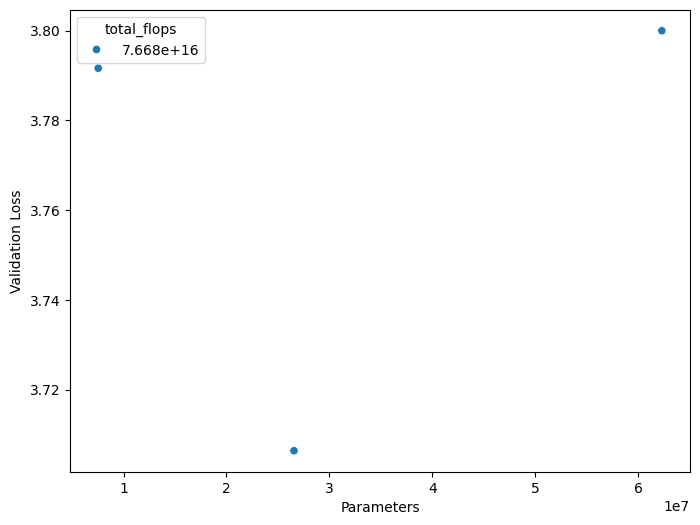

In [29]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(
    data=min_results,
    x="params",
    y="min_valid_loss",
    hue="total_flops",
    ax=ax,
    palette="tab20"
)
ax.set_xlabel("Parameters")
ax.set_ylabel("Validation Loss")
plt.show()